In [ ]:
import requests
import pandas as pd

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="IT"][admin_level=2];
node["amenity"="fuel"](area);
out body;
"""

response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

fuel_stations = []
for element in data['elements']:
    if element['type'] == 'node':
        fuel_stations.append({
            'id': element['id'],
            'latitude': element['lat'],
            'longitude': element['lon'],
            'name': element['tags'].get('name', 'Unknown')
        })

fuel_stations_df = pd.DataFrame(fuel_stations)

fuel_stations_df.to_csv('fuel_stations_italy.csv', index=False)

print(f"Retrieved {len(fuel_stations_df)} fuel stations in Italy.")

Retrieved 17643 fuel stations in Italy.


In [3]:
import geopandas as gpd
from geopandas import GeoDataFrame


# Create geometry column from longitude and latitude
geometry = gpd.points_from_xy(fuel_stations_df["longitude"], fuel_stations_df["latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(fuel_stations_df, geometry=geometry)

gdf.explore()

In [4]:
import numpy as np
from datetime import datetime, timedelta
from random import choices


num_vehicles = 20
num_employees = 20
num_cards = 20
num_transactions = 20000  # N transactions to 1 card

central_date = datetime(2024, 11, 1)  # Central date for distribution
date_std_dev = timedelta(hours=10)    # 30-day std deviation for variance

# Helper function to generate datetime within bounds using Gaussian distribution
def generate_dates(num_points, mean_date, std_dev_days):
    dates = [mean_date + timedelta(days=np.random.normal(0, std_dev_days)) for _ in range(num_points)]
    return dates

# Step 1: Create vehicles data
vehicles_data = {
    "vehicle_id": [f"U_{i:03}" for i in range(num_vehicles)],
    "max_capacity": np.random.uniform(30, 50, num_vehicles),
    "fuel_type": np.random.choice(["diesel", "fuel"], num_vehicles),
    "remaining_capacity": np.random.uniform(5, 50, num_vehicles),
    "avg_speed": np.random.uniform(40, 120, num_vehicles),
    "avg_fuel_consumption": np.random.uniform(5, 15, num_vehicles)
}
vehicles_df = pd.DataFrame(vehicles_data)

vehicles_df[['latitude', 'longitude']] = (
    fuel_stations_df[['latitude', 'longitude']]
    .sample(n=num_vehicles, replace=True)
    .reset_index(drop=True)
)
# Add a small random offset to spread the locations
vehicles_df['latitude'] += np.random.uniform(-0.05, 0.05, num_vehicles)
vehicles_df['longitude'] += np.random.uniform(-0.05, 0.05, num_vehicles)

# Step 2: Create employees data
employees_data = {
    "employee_id": [f"U_{i:03}" for i in range(num_employees)],
    "affidability": np.random.uniform(0, 1, num_employees),
    "vehicle_id": np.random.choice(vehicles_df["vehicle_id"], num_employees),
    "card_id": [f"U_{i:03}" for i in range(num_employees)]
}
employees_df = pd.DataFrame(employees_data)

# Step 3: Create cards data
max_amount = np.random.uniform(500, 1500, num_cards)
remaining_amount = np.random.uniform(0, max_amount)
cards_data = {
    "card_id": [f"U_{i:03}" for i in range(num_cards)],
    "max_amount": max_amount,
    "remaining_amount": remaining_amount,
    "employee_id": np.random.choice(employees_df["employee_id"], num_cards)
}
cards_df = pd.DataFrame(cards_data)

# Step 4: Create transactions data
transactions_data = {
    "transaction_id": [f"U_{i:03}" for i in range(num_transactions)],
    "amount": np.random.uniform(10, 60, num_transactions),
    "erogation_type": np.random.choice(["service", "self"], num_transactions),
    "card_id": np.random.choice(cards_df["card_id"], num_transactions),  # N:1 relationship
    "fuel_price": np.random.uniform(1.0, 2.5, num_transactions)
}
transactions_df = pd.DataFrame(transactions_data)

# Generate dates for transactions and card last transactions
transactions_df['time'] = generate_dates(num_transactions, central_date, date_std_dev.days)
cards_df['last_transaction'] = generate_dates(num_cards, central_date, date_std_dev.days)

# Step 5: Assign transaction locations based on vehicle locations
# Merge tables to get vehicle location for each transaction
transactions_df = transactions_df.merge(cards_df[['card_id', 'employee_id']], on='card_id', how='left')
transactions_df = transactions_df.merge(employees_df[['employee_id', 'vehicle_id']], on='employee_id', how='left')

# Rename columns to avoid conflicts in the next merge step
vehicles_df = vehicles_df.rename(columns={'latitude': 'latitude_vehicle', 'longitude': 'longitude_vehicle'})
transactions_df = transactions_df.merge(vehicles_df[['vehicle_id', 'latitude_vehicle', 'longitude_vehicle']], on='vehicle_id', how='left')

# Function to assign transaction location close to vehicle's location or randomly with a small chance
def assign_transaction_location(row, fuel_stations_df, random_chance=0.01):
    if np.random.rand() < random_chance:
        # Randomly select any fuel station in Italy
        selected_location = fuel_stations_df[['latitude', 'longitude']].sample(1).iloc[0]
    else:
        # Select a fuel station near the vehicle's location
        lat, lon = row['latitude_vehicle'], row['longitude_vehicle']
        nearby_stations = fuel_stations_df[
            (fuel_stations_df['latitude'].between(lat - 0.5, lat + 0.5)) &
            (fuel_stations_df['longitude'].between(lon - 0.5, lon + 0.5))
        ]
        
        if not nearby_stations.empty:
            selected_location = nearby_stations[['latitude', 'longitude']].sample(1).iloc[0]
        else:
            # If no nearby station, fallback to a random station
            selected_location = fuel_stations_df[['latitude', 'longitude']].sample(1).iloc[0]
    
    return pd.Series([selected_location['latitude'], selected_location['longitude']])

# Apply the function to each row in transactions_df
transactions_df[['latitude', 'longitude']] = transactions_df.apply(
    assign_transaction_location, axis=1, args=(fuel_stations_df,)
)

# Drop helper columns after assigning locations
transactions_df.drop(columns=['latitude_vehicle', 'longitude_vehicle'], inplace=True)

# Save DataFrames to CSV
vehicles_df.to_csv("vehicles.csv", index=False)
employees_df.to_csv("employees.csv", index=False)
cards_df.to_csv("cards.csv", index=False)
transactions_df.to_csv("transactions.csv", index=False)

print("Synthetic data with Italy-constrained locations and datetime elements generated and saved to CSV files.")



Synthetic data with Italy-constrained locations and datetime elements generated and saved to CSV files.


In [5]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance


def calculate_fuel_bought(transaction, vehicle):
    discount, surcharge = 0,0
    
    amount_spent = transaction['amount']
    fuel_price = transaction['fuel_price']
    erogation_type = transaction['erogation_type']

    fuel_bought = amount_spent / fuel_price

    if erogation_type == 'self':
        discount = -0.02
    elif erogation_type == 'service':
        surcharge = 0.03
        
    fuel_bought /= (1 + surcharge + discount)

    return fuel_bought # liters

def calculate_fuel_consumed(distance_taken, avg_fuel_consumption):
 
    fuel_consumed = distance_taken * avg_fuel_consumption
    
    return fuel_consumed


In [6]:
processed_matrix = []

for index, transaction in transactions_df.iterrows():
    card = cards_df[cards_df['card_id'] == transaction['card_id']]
    if not card.empty:
        card_id = card['card_id'].iloc[0]
        
        employee = employees_df[employees_df['card_id'] == card_id]
        if not employee.empty:
            employee = employee.iloc[0] 
            
            vehicle = vehicles_df[vehicles_df['vehicle_id'] == employee['vehicle_id']]
            if not vehicle.empty:
                vehicle = vehicle.iloc[0]
                
                distance_taken = haversine(vehicle.latitude_vehicle, vehicle.longitude_vehicle, transaction.latitude, transaction.longitude) # Km
                trans_amount = transaction.amount
                max_card_amount = card.max_amount.iloc[0] 
                remaining_amount = card.remaining_amount.iloc[0] 
                fuel_bought = calculate_fuel_bought(transaction, vehicle)
                fuel_consumed = calculate_fuel_consumed(distance_taken, vehicle.avg_fuel_consumption)
                empl_affidability = employee.affidability
                delta_time = pd.to_datetime(transaction.time) - pd.to_datetime(card.last_transaction.iloc[0] )
                vehicle_capacity = vehicle.max_capacity
                processed_data = {
   
                    'distance_taken' : distance_taken,
                    'trans_amount' : trans_amount,
                    'max_card_amount' : max_card_amount,
                    'remaining_amount': remaining_amount,
                    'fuel_bought': fuel_bought,
                    'empl_affidability': empl_affidability,
                    'vehicle_max_capacity': vehicle_capacity,
                    'fuel_consumed' : fuel_consumed,
                    'delta_time':  delta_time

                }
                
                processed_matrix.append(processed_data)
                
                
processed_df = pd.DataFrame(processed_matrix)

processed_df = processed_df[processed_df['delta_time'] >= pd.Timedelta(0)]

In [7]:
for index, element in processed_df.iterrows():
    if ((float(element['trans_amount']) > float(element['remaining_amount']))
        or (element['delta_time'] < pd.Timedelta(0))
        or (float(element['fuel_bought']) > float(element['vehicle_max_capacity']))):
        
        processed_df.at[index, 'label'] = 1
    else: 
        processed_df.at[index, 'label'] = 0

        
processed_df.to_csv('processed_transactions.csv', index=False)

print("Data saved to processed_transactions.csv")

i = 0
for index, element in processed_df.iterrows():
    if ((float(element['empl_affidability']) <= 0.1)
        and (element['delta_time'] < pd.Timedelta(days=1))):
        i += 1
        processed_df.at[index, 'label'] = 1
        
processed_df.to_csv('processed_transactions.csv', index=False)

print(i)

data = processed_df

random_fraud_percentage = 0.1  # e.g., 5% of data as random fraud
num_random_frauds = int(len(data) * random_fraud_percentage)

random_fraud_indices = np.random.choice(data.index, size=num_random_frauds, replace=False)

data.loc[random_fraud_indices, 'label'] = 1

data.to_csv('processed_transactions_with_random_frauds.csv', index=False)

print(f"Assigned random fraud labels to {num_random_frauds} rows.")


Data saved to processed_transactions.csv
1000
Assigned random fraud labels to 2000 rows.


In [8]:
import folium
from folium import plugins

transactions_df = pd.read_csv('transactions.csv', parse_dates=['time'])

vehicle_id = 'U_001'
vehicle_df = transactions_df[transactions_df['card_id'] == vehicle_id]

geometry = gpd.points_from_xy(vehicle_df['longitude'], vehicle_df['latitude'], crs="EPSG:4326")
gdf_vehicle = gpd.GeoDataFrame(vehicle_df, geometry=geometry)

map_center = [gdf_vehicle.iloc[0].geometry.y, gdf_vehicle.iloc[0].geometry.x]
m = folium.Map(location=map_center, zoom_start=12)

coordinates = list(zip(gdf_vehicle['latitude'], gdf_vehicle['longitude']))
for _, row in gdf_vehicle.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Time: {row['time']}, Amount: {row['amount']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)


m


Couldn't import dot_parser, loading of dot files will not be possible.
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - accuracy: 0.8428 - loss: 0.4380 - val_accuracy: 0.9043 - val_loss: 0.3114
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.9003 - loss: 0.3180 - val_accuracy: 0.9080 - val_loss: 0.2941
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9041 - loss: 0.3021 - val_accuracy: 0.9140 - val_loss: 0.2864
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.9083 - loss: 0.2936 - val_accuracy: 0.9113 - val_loss: 0.2874
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.9077 - loss: 0.2952 - val_accuracy: 0.9167 - val_loss: 0.2781
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.9126 - loss: 0.2807 - val_accuracy: 0.9143 - val_loss: 0.2799
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9089 - loss: 0.2883 - val_accuracy: 0.9140 - val_loss: 0.2780
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.9140 - loss: 0.2775 - val_accurac

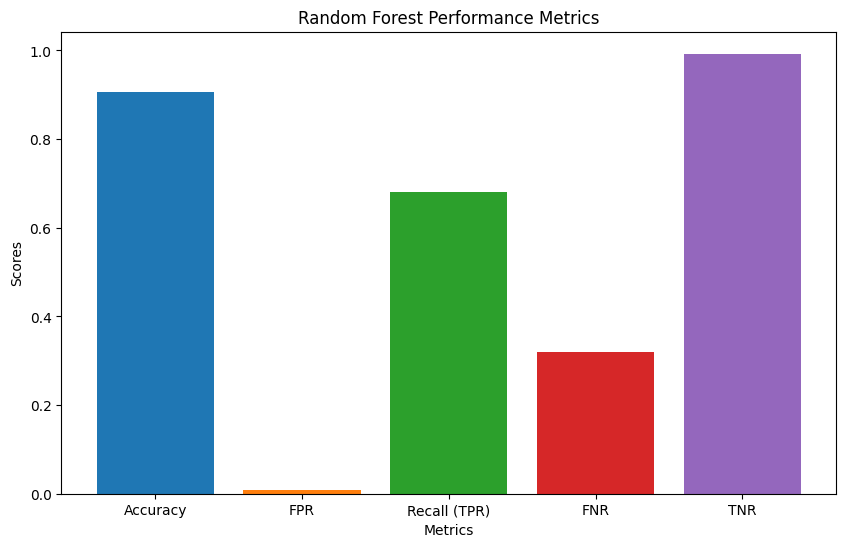

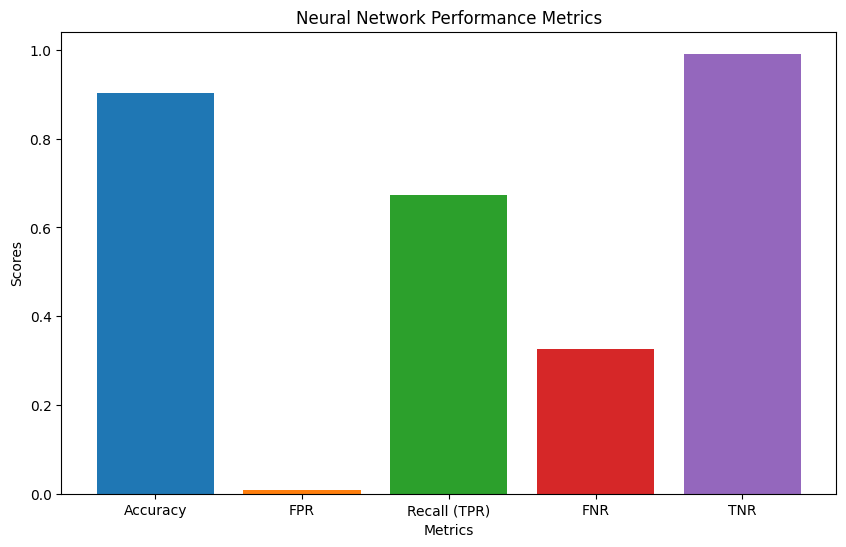

Random Forest Classifier:
Accuracy: 0.9066666666666666
FPR: 0.007359705611775529, Recall (TPR): 0.6803874092009685, FNR: 0.3196125907990315, TNR: 0.9926402943882244

Neural Network:
Accuracy: 0.9036666666666666
FPR: 0.008739650413983441, Recall (TPR): 0.6731234866828087, FNR: 0.3268765133171913, TNR: 0.9912603495860166


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
data = pd.read_csv('processed_transactions_with_random_frauds.csv')
data['delta_time_seconds'] = pd.to_timedelta(data['delta_time']).dt.total_seconds()

# Define features and labels
features = data.drop(columns=['delta_time', 'label'])
labels = data['label']

# Split the data
X_train_full, X_temp, y_train_full, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_full, y_train_full)

# Train Neural Network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_full.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_full, y_train_full, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate Random Forest
y_test_rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_test_rf_pred)
rf_cm = confusion_matrix(y_test, y_test_rf_pred)
rf_tn, rf_fp, rf_fn, rf_tp = rf_cm.ravel()
rf_fpr = rf_fp / (rf_fp + rf_tn)
rf_tpr = rf_tp / (rf_tp + rf_fn)  # Recall
rf_fnr = rf_fn / (rf_fn + rf_tp)
rf_tnr = rf_tn / (rf_tn + rf_fp)

# Evaluate Neural Network
y_test_nn_pred = (nn_model.predict(X_test) > 0.5).astype("int32")
nn_accuracy = accuracy_score(y_test, y_test_nn_pred)
nn_cm = confusion_matrix(y_test, y_test_nn_pred)
nn_tn, nn_fp, nn_fn, nn_tp = nn_cm.ravel()
nn_fpr = nn_fp / (nn_fp + nn_tn)
nn_tpr = nn_tp / (nn_tp + nn_fn)  # Recall
nn_fnr = nn_fn / (nn_fn + nn_tp)
nn_tnr = nn_tn / (nn_tn + nn_fp)

# Plot 1: Random Forest Metrics
fig, ax_rf = plt.subplots(figsize=(10, 6))
metrics_rf = [rf_accuracy, rf_fpr, rf_tpr, rf_fnr, rf_tnr]
labels_rf = ['Accuracy', 'FPR', 'Recall (TPR)', 'FNR', 'TNR']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
ax_rf.bar(labels_rf, metrics_rf, color=colors)
ax_rf.set_xlabel('Metrics')
ax_rf.set_ylabel('Scores')
ax_rf.set_title('Random Forest Performance Metrics')
plt.show()

# Plot 2: Neural Network Metrics
fig, ax_nn = plt.subplots(figsize=(10, 6))
metrics_nn = [nn_accuracy, nn_fpr, nn_tpr, nn_fnr, nn_tnr]
labels_nn = ['Accuracy', 'FPR', 'Recall (TPR)', 'FNR', 'TNR']
ax_nn.bar(labels_nn, metrics_nn, color=colors)
ax_nn.set_xlabel('Metrics')
ax_nn.set_ylabel('Scores')
ax_nn.set_title('Neural Network Performance Metrics')
plt.show()

# Print results
print("Random Forest Classifier:")
print(f"Accuracy: {rf_accuracy}")
print(f"FPR: {rf_fpr}, Recall (TPR): {rf_tpr}, FNR: {rf_fnr}, TNR: {rf_tnr}")

print("\nNeural Network:")
print(f"Accuracy: {nn_accuracy}")
print(f"FPR: {nn_fpr}, Recall (TPR): {nn_tpr}, FNR: {nn_fnr}, TNR: {nn_tnr}")

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - accuracy: 0.8357 - loss: 0.4376 - val_accuracy: 0.8980 - val_loss: 0.3213
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.8994 - loss: 0.3228 - val_accuracy: 0.9100 - val_loss: 0.2976
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.9057 - loss: 0.2989 - val_accuracy: 0.9130 - val_loss: 0.2920
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.8987 - loss: 0.3087 - val_accuracy: 0.9107 - val_loss: 0.2851
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.9078 - loss: 0.2930 - val_accuracy: 0.9120 - val_loss: 0.2883
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.9073 - loss: 0.2917 - val_accuracy: 0.9107 - val_loss: 0.2819
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.9056 - loss: 0.2936 - val_accuracy: 0.9083 - val_loss: 0.2823
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.9069 - loss: 0.2899 - val_accurac

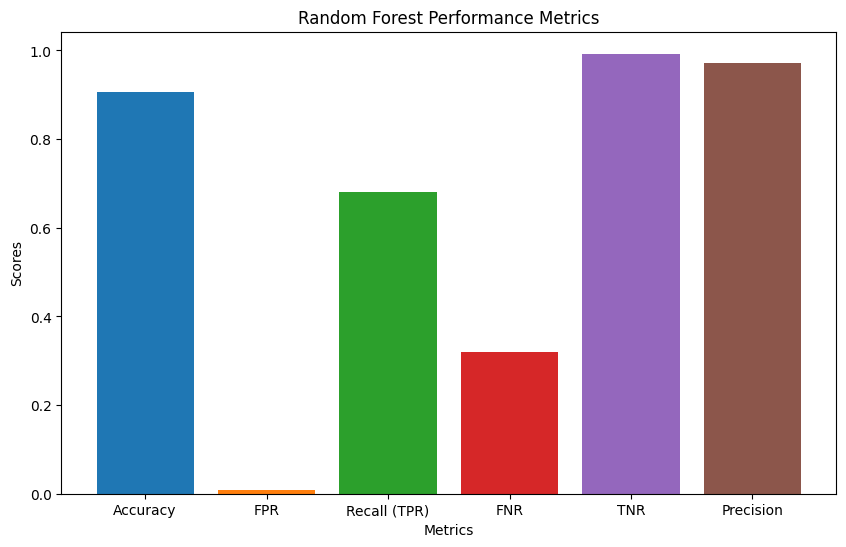

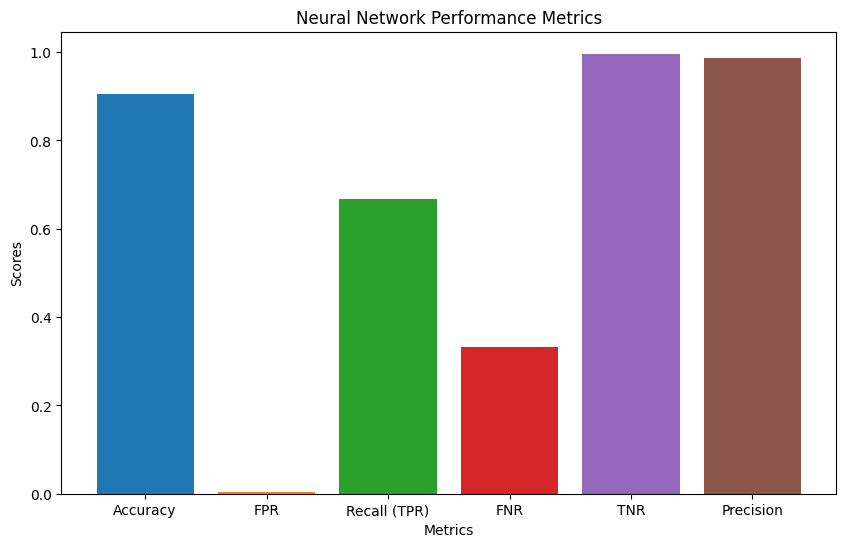

Random Forest Classifier:
Accuracy: 0.9066666666666666
FPR: 0.007359705611775529, Recall (TPR): 0.6803874092009685, FNR: 0.3196125907990315, TNR: 0.9926402943882244, Precision: 0.972318339100346

Neural Network:
Accuracy: 0.906
FPR: 0.0036798528058877645, Recall (TPR): 0.6682808716707022, FNR: 0.33171912832929784, TNR: 0.9963201471941122, Precision: 0.9857142857142858


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
data = pd.read_csv('processed_transactions_with_random_frauds.csv')
data['delta_time_seconds'] = pd.to_timedelta(data['delta_time']).dt.total_seconds()

# Define features and labels
features = data.drop(columns=['delta_time', 'label'])
labels = data['label']

# Split the data
X_train_full, X_temp, y_train_full, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_full, y_train_full)

# Train Neural Network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_full.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_full, y_train_full, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate Random Forest
y_test_rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_test_rf_pred)
rf_cm = confusion_matrix(y_test, y_test_rf_pred)
rf_tn, rf_fp, rf_fn, rf_tp = rf_cm.ravel()
rf_fpr = rf_fp / (rf_fp + rf_tn)
rf_tpr = rf_tp / (rf_tp + rf_fn)  # Recall
rf_fnr = rf_fn / (rf_fn + rf_tp)
rf_tnr = rf_tn / (rf_tn + rf_fp)
rf_precision = rf_tp / (rf_tp + rf_fp)

# Evaluate Neural Network
y_test_nn_pred = (nn_model.predict(X_test) > 0.5).astype("int32")
nn_accuracy = accuracy_score(y_test, y_test_nn_pred)
nn_cm = confusion_matrix(y_test, y_test_nn_pred)
nn_tn, nn_fp, nn_fn, nn_tp = nn_cm.ravel()
nn_fpr = nn_fp / (nn_fp + nn_tn)
nn_tpr = nn_tp / (nn_tp + nn_fn)  # Recall
nn_fnr = nn_fn / (nn_fn + nn_tp)
nn_tnr = nn_tn / (nn_tn + nn_fp)
nn_precision = nn_tp / (nn_tp + nn_fp)

# Plot 1: Random Forest Metrics
fig, ax_rf = plt.subplots(figsize=(10, 6))
metrics_rf = [rf_accuracy, rf_fpr, rf_tpr, rf_fnr, rf_tnr, rf_precision]
labels_rf = ['Accuracy', 'FPR', 'Recall (TPR)', 'FNR', 'TNR', 'Precision']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
ax_rf.bar(labels_rf, metrics_rf, color=colors)
ax_rf.set_xlabel('Metrics')
ax_rf.set_ylabel('Scores')
ax_rf.set_title('Random Forest Performance Metrics')
plt.show()

# Plot 2: Neural Network Metrics
fig, ax_nn = plt.subplots(figsize=(10, 6))
metrics_nn = [nn_accuracy, nn_fpr, nn_tpr, nn_fnr, nn_tnr, nn_precision]
labels_nn = ['Accuracy', 'FPR', 'Recall (TPR)', 'FNR', 'TNR', 'Precision']
ax_nn.bar(labels_nn, metrics_nn, color=colors)
ax_nn.set_xlabel('Metrics')
ax_nn.set_ylabel('Scores')
ax_nn.set_title('Neural Network Performance Metrics')
plt.show()

# Print results
print("Random Forest Classifier:")
print(f"Accuracy: {rf_accuracy}")
print(f"FPR: {rf_fpr}, Recall (TPR): {rf_tpr}, FNR: {rf_fnr}, TNR: {rf_tnr}, Precision: {rf_precision}")

print("\nNeural Network:")
print(f"Accuracy: {nn_accuracy}")
print(f"FPR: {nn_fpr}, Recall (TPR): {nn_tpr}, FNR: {nn_fnr}, TNR: {nn_tnr}, Precision: {nn_precision}")